In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager
from copy import copy
import pandas as pd
import datetime

In [2]:
%matplotlib inline

label_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=20
)
tick_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=14
)
pub_font = font_manager.FontProperties(
#     family=['cmr10'],
    weight='regular',
    size=32
)
publish = False
if publish:
    matplotlib.rcParams.update(
        {
            'text.usetex': True,
            'font.family': 'cmr10',
            'mathtext.fontset': 'cm',
        }
    )

In [3]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+R+G+H),
        b*S*I/(S+E+I+R+G+H)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        e*I,
        m*I,
        g*E,
        e*I
    ]

In [4]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa-data/samoa_press_release_data.csv", 
                           header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [5]:
the_dates = list(map(lambda t: datetime.datetime.strptime(t, "%d/%m/%Y"), raw_data.Date.values))
def time_conv(time: float):
    return the_dates[0] + datetime.timedelta(days=time)

In [6]:
date_tick = [datetime.date(2019, M, 1) for M in [10, 11, 12]] + [datetime.date(2020, 1, 1)]
date_tick_label = ['Oct\n2019', 'Nov', 'Dec', 'Jan\n2020']

ex_date_tick = date_tick + [datetime.date(2020,2,1)]
ex_date_label = date_tick_label + ['Feb']

In [7]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

In [8]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
clip = 17
data_time = time[start:clip]
data_pd = data_pd[start:clip,:]

p0 = [2, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
#     "time_span": [time[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [9]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [10]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
fr_ex = ca.Function('fr_ex', [solver_setup['x']], [objective.regularisation])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)

In [11]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 3e1

In [12]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0


  50 3.8323236e+001 0.00e+000 1.05e-001  -3.8 3.59e+003    -  1.00e+000 1.00e+000f  1
 100 3.8333707e+001 0.00e+000 5.15e-001  -3.8 3.50e+001  -8.2 1.00e+000 1.00e+000f  1
 150 3.8268993e+001 0.00e+000 7.33e-001  -5.7 6.06e+003    -  8.48e-001 5.00e-001f  2
 200 3.8256390e+001 0.00e+000 4.86e-002  -5.7 1.53e+001    -  1.00e+000 1.00e+000f  1
 250 3.8254948e+001 0.00e+000 3.25e-003  -5.7 4.06e+000    -  1.00e+000 1.00e+000h  1
 300 3.8254576e+001 0.00e+000 7.87e-002  -5.7 1.35e+001    -  1.00e+000 1.00e+000h  1
 350 3.8253969e+001 0.00e+000 1.36e-003  -8.6 3.72e+000    -  1.00e+000 1.00e+000h  1
 400 3.8253863e+001 0.00e+000 6.65e-002  -8.6 3.77e+001    -  1.00e+000 1.00e+000h  1
 450 3.8253806e+001 0.00e+000 1.91e-003  -8.6 1.07e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.8253776e+001 0.00e+000 1.50e-002  -8.6 4.28e+001    -  1.00e+000 1.00e+000h  1
 550 3.8253757e+001 0.00e+000 3.44e-004  -8.6 1.04e+001    

1200 3.8341352e+001 0.00e+000 1.95e-003  -8.6 2.68e+002    -  1.00e+000 1.00e+000h  1
1250 3.8341352e+001 0.00e+000 1.03e-002  -8.6 1.38e+003    -  1.00e+000 5.00e-001h  2
1300 3.8341351e+001 0.00e+000 2.67e-004  -8.6 1.28e+002    -  1.00e+000 1.00e+000h  1
1350 3.8341351e+001 0.00e+000 4.83e-003  -8.6 1.18e+003    -  1.00e+000 5.00e-001h  2
1400 3.8341351e+001 0.00e+000 2.63e-004  -8.6 1.60e+002    -  1.00e+000 1.00e+000h  1
1450 3.8341351e+001 0.00e+000 8.40e-003  -8.6 1.53e+004    -  1.00e+000 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 3.8341350e+001 0.00e+000 1.93e-003  -8.6 9.89e+002    -  1.00e+000 5.00e-001h  2
1550 3.8341350e+001 0.00e+000 8.11e-003  -8.6 2.27e+003    -  1.00e+000 5.00e-001h  2
1600 3.8341350e+001 0.00e+000 7.37e-004  -8.6 3.64e+002    -  1.00e+000 1.00e+000h  1
1650 3.8341350e+001 0.00e+000 8.58e-004  -8.6 4.11e+002    -  1.00e+000 1.00e+000h  1
1700 3.8341350e+001 0.00e+000 2.10e-003  -8.6 6.69e+002    

1750 3.8445453e+001 0.00e+000 5.12e-004  -8.6 2.70e+002    -  1.00e+000 1.00e+000h  1
1800 3.8445452e+001 0.00e+000 1.21e-003  -8.6 4.30e+002    -  1.00e+000 1.00e+000h  1
1850 3.8445452e+001 0.00e+000 2.28e-003  -8.6 2.13e+003    -  1.00e+000 2.50e-001h  3
1900 3.8445452e+001 0.00e+000 8.59e-004  -8.6 3.93e+002    -  1.00e+000 1.00e+000h  1
1950 3.8445452e+001 0.00e+000 4.35e-003  -8.6 3.47e+003    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 3.8445452e+001 0.00e+000 3.39e-003  -8.6 3.16e+003    -  1.00e+000 2.50e-001h  3
2050 3.8445452e+001 0.00e+000 6.47e-005  -8.6 1.24e+002    -  1.00e+000 1.00e+000h  1
2100 3.8445452e+001 0.00e+000 9.06e-003  -8.6 7.24e+003    -  1.00e+000 1.25e-001h  4
2150 3.8445452e+001 0.00e+000 3.85e-004  -8.6 3.12e+002    -  1.00e+000 1.00e+000h  1
2200 3.8445452e+001 0.00e+000 2.18e-005  -8.6 8.25e+001    -  1.00e+000 1.00e+000h  1
2250 3.8445452e+001 0.00e+000 6.26e-004  -8.6 4.22e+002    

1750 3.8567581e+001 0.00e+000 7.92e-004  -8.6 2.94e+002    -  1.00e+000 1.00e+000h  1
1800 3.8567581e+001 0.00e+000 7.92e-003  -8.6 9.63e+002    -  1.00e+000 1.00e+000h  1
1850 3.8567581e+001 0.00e+000 2.56e-004  -8.6 1.83e+002    -  1.00e+000 1.00e+000h  1
1900 3.8567581e+001 0.00e+000 4.36e-002  -8.6 1.86e+004    -  1.00e+000 3.12e-002h  6
1950 3.8567581e+001 0.00e+000 5.94e-005  -8.6 9.83e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 3.8567580e+001 0.00e+000 1.01e-002  -8.6 2.51e+003    -  1.00e+000 5.00e-001h  2
2050 3.8567580e+001 0.00e+000 5.59e-006  -8.6 4.50e+001    -  1.00e+000 1.00e+000h  1
2100 3.8567580e+001 0.00e+000 8.50e-004  -8.6 3.96e+002    -  1.00e+000 1.00e+000h  1
2150 3.8567580e+001 0.00e+000 3.47e-003  -8.6 8.21e+002    -  1.00e+000 1.00e+000h  1
2200 3.8567580e+001 0.00e+000 1.07e-001  -8.6 4.50e+004    -  1.00e+000 1.56e-002h  7
2250 3.8567580e+001 0.00e+000 5.68e-003  -8.6 1.12e+003    

1800 3.8708380e+001 0.00e+000 5.98e-003  -8.6 6.03e+002    -  1.00e+000 1.00e+000h  1
1850 3.8708380e+001 0.00e+000 4.87e-003  -8.6 1.08e+003    -  1.00e+000 5.00e-001h  2
1900 3.8708379e+001 0.00e+000 5.60e-005  -8.6 6.82e+001    -  1.00e+000 1.00e+000h  1
1950 3.8708379e+001 0.00e+000 2.91e-002  -8.6 6.65e+003    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 3.8708379e+001 0.00e+000 5.10e-003  -8.6 1.26e+003    -  1.00e+000 5.00e-001h  2
2050 3.8708379e+001 0.00e+000 7.16e-002  -8.6 1.59e+004    -  1.00e+000 3.12e-002h  6
2100 3.8708379e+001 0.00e+000 9.55e-005  -8.6 1.02e+002    -  1.00e+000 1.00e+000h  1
2150 3.8708379e+001 0.00e+000 5.54e-003  -8.6 7.74e+002    -  1.00e+000 1.00e+000h  1
2200 3.8708378e+001 0.00e+000 1.26e-003  -8.6 3.83e+002    -  1.00e+000 1.00e+000h  1
2250 3.8708378e+001 0.00e+000 4.83e-004  -8.6 2.46e+002    -  1.00e+000 1.00e+000h  1
2300 3.8708378e+001 0.00e+000 5.13e-002  -8.6 1.17e+004    


Number of Iterations....: 1785

                                   (scaled)                 (unscaled)
Objective...............:  3.8867691458159065e+001   3.8867691458159065e+001
Dual infeasibility......:  3.9636953256584995e-009   3.9636953256584995e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059036572383148e-009   2.5059036572383148e-009
Overall NLP error.......:  3.9636953256584995e-009   3.9636953256584995e-009


Number of objective function evaluations             = 3523
Number of objective gradient evaluations             = 1786
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 3523
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1786
Number of Lagrangian Hessian evaluations             = 1785
Total CPU secs in IPOPT (w/o function evaluations)   =     10.612
Total CPU secs in NLP functio

  50 4.0683340e+001 0.00e+000 3.91e+001  -2.5 9.73e+003    -  1.00e+000 8.29e-001f  1
 100 4.1066597e+001 0.00e+000 1.56e+001  -2.5 1.90e+004    -  1.00e+000 1.00e+000f  1
 150 4.0234929e+001 0.00e+000 6.88e+000  -5.7 3.47e+003 -11.2 1.00e+000 1.00e+000f  1
 200 3.9438227e+001 0.00e+000 3.95e+000  -5.7 4.14e+003 -11.8 1.00e+000 7.88e-001f  1
 250 3.9260622e+001 0.00e+000 2.13e+000  -5.7 1.73e+002    -  1.00e+000 2.50e-001f  3
 300 3.9250709e+001 0.00e+000 8.93e-002  -5.7 3.16e+000    -  1.00e+000 1.00e+000f  1
 350 3.9247999e+001 0.00e+000 6.83e-002  -5.7 2.23e+000    -  1.00e+000 1.00e+000h  1
 400 3.9246813e+001 0.00e+000 1.37e-002  -5.7 1.82e+000    -  1.00e+000 1.00e+000h  1
 450 3.9246290e+001 0.00e+000 3.80e-002  -5.7 4.42e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.9245967e+001 0.00e+000 2.99e-004  -5.7 9.62e-001    -  1.00e+000 1.00e+000f  1
 550 3.9245815e+001 0.00e+000 5.22e-002  -5.7 1.58e+002    

 800 3.9467316e+001 0.00e+000 1.02e-002  -8.6 1.76e+001    -  1.00e+000 1.00e+000h  1
 850 3.9467295e+001 0.00e+000 5.91e-003  -8.6 1.66e+001    -  1.00e+000 1.00e+000h  1
 900 3.9467279e+001 0.00e+000 3.50e-003  -8.6 1.56e+001    -  1.00e+000 1.00e+000h  1
 950 3.9467266e+001 0.00e+000 3.34e-003  -8.6 1.86e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 3.9467256e+001 0.00e+000 5.86e-002  -8.6 3.64e+002    -  1.00e+000 2.50e-001h  3
1050 3.9467249e+001 0.00e+000 4.58e-002  -8.6 9.61e+001    -  1.00e+000 1.00e+000h  1
1100 3.9467243e+001 0.00e+000 4.66e-003  -8.6 3.57e+001    -  1.00e+000 1.00e+000h  1
1150 3.9467238e+001 0.00e+000 3.76e-003  -8.6 3.68e+001    -  1.00e+000 1.00e+000h  1
1200 3.9467234e+001 0.00e+000 1.73e-002  -8.6 8.96e+001    -  1.00e+000 1.00e+000h  1
1250 3.9467231e+001 0.00e+000 3.39e-002  -8.6 2.29e+003    -  1.00e+000 3.12e-002h  6
1300 3.9467228e+001 0.00e+000 1.40e-002  -8.6 1.86e+002    

 700 3.9741713e+001 0.00e+000 1.11e-001  -8.6 6.41e+001    -  1.00e+000 5.00e-001h  2
 750 3.9741681e+001 0.00e+000 6.15e-002  -8.6 3.08e+001    -  1.00e+000 1.00e+000h  1
 800 3.9741658e+001 0.00e+000 2.70e-002  -8.6 2.47e+001    -  1.00e+000 1.00e+000h  1
 850 3.9741638e+001 0.00e+000 1.79e-003  -8.6 7.98e+000    -  1.00e+000 1.00e+000h  1
 900 3.9741623e+001 0.00e+000 5.19e-003  -8.6 1.59e+001    -  1.00e+000 1.00e+000h  1
 950 3.9741617e+001 0.00e+000 2.73e-001  -8.6 1.34e+002    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 3.9741600e+001 0.00e+000 2.94e-003  -8.6 1.71e+001    -  1.00e+000 1.00e+000h  1
1050 3.9741591e+001 0.00e+000 5.28e-002  -8.6 2.45e+003    -  1.00e+000 3.12e-002h  6
1100 3.9743422e+001 0.00e+000 4.98e+000  -8.6 9.76e+002    -  1.00e+000 1.00e+000H  1
1150 3.9741579e+001 0.00e+000 7.40e-003  -8.6 4.43e+001    -  1.00e+000 1.00e+000h  1
1200 3.9741575e+001 0.00e+000 1.72e-002  -8.6 7.70e+001    

 650 4.0094180e+001 0.00e+000 3.93e-002  -5.7 4.57e+000    -  1.00e+000 1.00e+000h  1
 700 4.0094060e+001 0.00e+000 9.44e-002  -5.7 6.76e+001    -  1.00e+000 1.25e-001h  4
 750 4.0093977e+001 0.00e+000 4.40e-004  -5.7 7.84e-001    -  1.00e+000 1.00e+000h  1
 800 4.0093918e+001 0.00e+000 2.89e-002  -5.7 1.26e+001    -  1.00e+000 5.00e-001h  2
 850 4.0093510e+001 0.00e+000 8.95e-002  -8.6 1.51e+001    -  1.00e+000 1.00e+000h  1
 900 4.0093452e+001 0.00e+000 2.05e-002  -8.6 9.11e+000    -  1.00e+000 1.00e+000h  1
 950 4.0093408e+001 0.00e+000 2.26e-002  -8.6 1.18e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.0093376e+001 0.00e+000 6.27e-002  -8.6 2.35e+001    -  1.00e+000 1.00e+000h  1
1050 4.0093351e+001 0.00e+000 5.79e-002  -8.6 2.72e+001    -  1.00e+000 1.00e+000h  1
1100 4.0093330e+001 0.00e+000 1.10e-002  -8.6 1.41e+001    -  1.00e+000 1.00e+000h  1
1150 4.0093314e+001 0.00e+000 1.40e-002  -8.6 1.89e+001    

 650 4.0530007e+001 0.00e+000 1.66e-001  -5.7 1.91e+001    -  1.00e+000 5.00e-001h  2
 700 4.0529930e+001 0.00e+000 1.13e-005  -5.7 6.97e+000    -  1.00e+000 1.00e+000h  1
 750 4.0529471e+001 0.00e+000 4.28e-001  -8.6 4.43e+001    -  1.00e+000 5.00e-001h  2
 800 4.0529375e+001 0.00e+000 2.31e-001  -8.6 4.38e+001    -  1.00e+000 5.00e-001h  2
 850 4.0529331e+001 0.00e+000 6.84e-002  -8.6 2.49e+001    -  1.00e+000 5.00e-001h  2
 900 4.0529297e+001 0.00e+000 1.40e-002  -8.6 8.00e+000    -  1.00e+000 1.00e+000h  1
 950 4.0529270e+001 0.00e+000 6.17e-004  -8.6 2.28e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.0529248e+001 0.00e+000 2.48e-002  -8.6 1.47e+001    -  1.00e+000 1.00e+000h  1
1050 4.0529230e+001 0.00e+000 2.32e-003  -8.6 5.40e+000    -  1.00e+000 1.00e+000h  1
1100 4.0529216e+001 0.00e+000 3.89e-002  -8.6 2.49e+001    -  1.00e+000 1.00e+000h  1
1150 4.0529204e+001 0.00e+000 5.63e-003  -8.6 1.10e+001    

 600 4.1038199e+001 0.00e+000 4.99e-001  -5.7 3.22e+001    -  1.00e+000 1.25e-001h  4
 650 4.1037644e+001 0.00e+000 2.20e-002  -5.7 1.24e+000    -  1.00e+000 1.00e+000h  1
 700 4.1037326e+001 0.00e+000 8.62e-003  -5.7 1.04e+000    -  1.00e+000 1.00e+000h  1
 750 4.1037112e+001 0.00e+000 1.12e-001  -5.7 1.46e+002    -  1.00e+000 3.12e-002h  6
 800 4.1036986e+001 0.00e+000 2.36e-001  -5.7 1.57e+001    -  1.00e+000 5.00e-001h  2
 850 4.1036896e+001 0.00e+000 2.53e-002  -5.7 3.13e+000    -  1.00e+000 1.00e+000h  1
 900 4.1036830e+001 0.00e+000 4.91e-003  -5.7 1.60e+000    -  1.00e+000 1.00e+000h  1
 950 4.1036786e+001 0.00e+000 6.40e-002  -5.7 2.51e+001    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.1036762e+001 0.00e+000 1.83e-003  -5.7 2.29e+000    -  1.00e+000 5.00e-001h  2
1050 4.1036287e+001 0.00e+000 1.91e-001  -8.6 1.39e+001    -  1.00e+000 1.00e+000h  1
1100 4.1036239e+001 0.00e+000 2.90e-001  -8.6 2.05e+001    

 650 4.1626159e+001 0.00e+000 8.74e-002  -5.7 3.14e+000    -  1.00e+000 1.00e+000h  1
 700 4.1626028e+001 0.00e+000 4.93e-003  -5.7 9.36e-001    -  1.00e+000 1.00e+000h  1
 750 4.1625940e+001 0.00e+000 1.83e-002  -5.7 2.07e+000    -  1.00e+000 1.00e+000h  1
 800 4.1625884e+001 0.00e+000 1.99e-002  -5.7 2.43e+000    -  1.00e+000 1.00e+000h  1
 850 4.1625845e+001 0.00e+000 3.19e-002  -5.7 6.27e+000    -  1.00e+000 5.00e-001h  2
 900 4.1625824e+001 0.00e+000 1.51e-002  -5.7 9.78e+000    -  1.00e+000 2.50e-001h  3
 950 4.1625575e+001 0.00e+000 3.15e+000  -8.6 4.18e+001    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.1625297e+001 0.00e+000 1.70e-001  -8.6 2.19e+001    -  1.00e+000 5.00e-001h  2
1050 4.1625257e+001 0.00e+000 1.22e-001  -8.6 2.18e+001    -  1.00e+000 5.00e-001h  2
1100 4.1625230e+001 0.00e+000 1.06e-001  -8.6 1.27e+001    -  1.00e+000 1.00e+000h  1
1150 4.1625207e+001 0.00e+000 2.34e-001  -8.6 8.57e+001    

 600 4.2972277e+001 0.00e+000 2.62e-002  -5.7 1.61e+000    -  1.00e+000 1.00e+000f  1
 650 4.2971639e+001 0.00e+000 5.52e-003  -5.7 1.13e+000    -  1.00e+000 1.00e+000f  1
 700 4.2971230e+001 0.00e+000 2.86e-001  -5.7 1.65e+001    -  1.00e+000 5.00e-001h  2
 750 4.2970964e+001 0.00e+000 5.55e-002  -5.7 5.23e+000    -  1.00e+000 1.00e+000h  1
 800 4.2970774e+001 0.00e+000 9.86e-002  -5.7 8.60e+000    -  1.00e+000 1.00e+000h  1
 850 4.2970625e+001 0.00e+000 2.83e-001  -5.7 3.47e+001    -  1.00e+000 5.00e-001h  2
 900 4.2970519e+001 0.00e+000 3.07e-001  -5.7 4.39e+001    -  1.00e+000 5.00e-001h  2
 950 4.2970449e+001 0.00e+000 1.75e-002  -5.7 6.15e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.2970399e+001 0.00e+000 5.30e-002  -5.7 1.19e+001    -  1.00e+000 1.00e+000h  1
1050 4.2970364e+001 0.00e+000 2.35e-003  -5.7 2.76e+000    -  1.00e+000 1.00e+000h  1
1100 4.2970146e+001 0.00e+000 1.78e-001  -8.6 2.44e+002    

 550 4.3895591e+001 0.00e+000 1.23e-001  -3.8 9.31e+000    -  1.00e+000 1.00e+000h  1
 600 4.3831843e+001 0.00e+000 1.10e+001  -5.7 9.73e+002    -  3.11e-001 1.00e+000f  1
 650 4.3822898e+001 0.00e+000 1.15e+000  -5.7 2.61e+000    -  1.00e+000 1.00e+000f  1
 700 4.3818676e+001 0.00e+000 1.17e+000  -5.7 3.22e+000    -  1.00e+000 1.00e+000f  1
 750 4.3816342e+001 0.00e+000 5.84e-001  -5.7 5.27e+001    -  1.00e+000 6.25e-002f  5
 800 4.3814918e+001 0.00e+000 4.45e-001  -5.7 4.35e+000    -  1.00e+000 1.00e+000h  1
 850 4.3814024e+001 0.00e+000 1.62e-001  -5.7 3.67e+000    -  1.00e+000 1.00e+000h  1
 900 4.3813441e+001 0.00e+000 6.01e-001  -5.7 7.39e+001    -  1.00e+000 1.25e-001h  4
 950 4.3813120e+001 0.00e+000 1.97e+000  -5.7 4.37e+001    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.3812785e+001 0.00e+000 4.64e-003  -5.7 1.50e+000    -  1.00e+000 1.00e+000h  1
1050 4.3812591e+001 0.00e+000 3.73e-001  -5.7 2.88e+001    

 500 4.4962481e+001 0.00e+000 1.71e+001  -3.8 1.25e+004 -10.1 1.37e-001 7.80e-003f  4
 550 4.4863456e+001 0.00e+000 5.97e+000  -3.8 3.18e+001    -  1.00e+000 1.00e+000f  1
 600 4.4837825e+001 0.00e+000 3.00e-001  -3.8 3.79e+000    -  1.00e+000 1.00e+000f  1
 650 4.4777286e+001 0.00e+000 4.77e-001  -5.7 1.26e+001    -  1.00e+000 1.00e+000f  1
 700 4.4767517e+001 0.00e+000 2.08e+000  -5.7 1.53e+001    -  1.00e+000 2.50e-001f  3
 750 4.4762640e+001 0.00e+000 2.66e+000  -5.7 3.71e+000    -  1.00e+000 1.00e+000f  1
 800 4.4759847e+001 0.00e+000 2.86e-001  -5.7 1.84e+000    -  1.00e+000 1.00e+000f  1
 850 4.4758198e+001 0.00e+000 1.28e-001  -5.7 1.76e+000    -  1.00e+000 1.00e+000h  1
 900 4.4757097e+001 0.00e+000 2.33e-001  -5.7 3.26e+000    -  1.00e+000 1.00e+000h  1
 950 4.4756369e+001 0.00e+000 5.52e-001  -5.7 1.05e+002    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.4755876e+001 0.00e+000 1.04e-002  -5.7 1.30e+000    

 500 4.6886863e+001 0.00e+000 3.23e+000  -5.7 1.55e+003 -12.4 1.00e+000 2.50e-001f  3
 550 4.6877338e+001 0.00e+000 2.93e+000  -5.7 1.76e+002 -10.0 1.00e+000 1.00e+000f  1
 600 4.6871570e+001 0.00e+000 4.93e-003  -5.7 1.84e+000  -8.5 1.00e+000 1.00e+000f  1
 650 4.6870316e+001 0.00e+000 3.03e-005  -8.6 2.46e-001  -6.1 1.00e+000 1.00e+000f  1

Number of Iterations....: 695

                                   (scaled)                 (unscaled)
Objective...............:  4.6870197880305589e+001   4.6870197880305589e+001
Dual infeasibility......:  4.9150491620282513e-009   4.9150491620282513e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.2299528459699172e-010   9.2299528459699172e-010
Overall NLP error.......:  4.9150491620282513e-009   4.9150491620282513e-009


Number of objective function evaluations             = 1172
Number of objective gradient evaluations             = 696
Number of equality constraint evaluations      

  50 5.1810880e+001 0.00e+000 1.74e+001  -2.5 1.81e+004    -  7.03e-001 2.50e-001f  3
 100 5.1104497e+001 0.00e+000 1.30e+000  -3.8 1.67e+004 -13.0 1.00e+000 2.56e-002f  5
 150 5.1072231e+001 0.00e+000 5.67e-001  -5.7 2.66e+002 -11.5 1.00e+000 1.00e+000f  1
 200 5.1056805e+001 0.00e+000 6.21e-001  -5.7 5.01e+002 -11.9 1.00e+000 1.00e+000f  1
 250 5.1029555e+001 0.00e+000 4.91e+000  -5.7 3.53e+002 -11.4 1.00e+000 1.00e+000f  1
 300 5.0992404e+001 0.00e+000 1.50e+000  -5.7 3.82e+002 -11.7 1.00e+000 1.00e+000f  1
 350 5.0965979e+001 0.00e+000 3.68e+001  -5.7 1.74e+005    -  6.70e-003 1.18e-002f  1
 400 5.0954866e+001 0.00e+000 5.75e-002  -8.6 6.78e+001 -12.0 1.00e+000 9.94e-001f  1

Number of Iterations....: 431

                                   (scaled)                 (unscaled)
Objective...............:  5.0954443258263069e+001   5.0954443258263069e+001
Dual infeasibility......:  1.1679889013332752e-010   1.1679889013332752e-010
Constraint violation....:  0.0000000000000000e+000   0.

  50 9.2672422e+001 0.00e+000 3.63e+002  -1.0 4.72e+003    -  1.00e+000 1.00e+000f  1
 100 5.8164848e+001 0.00e+000 9.76e+001  -3.8 1.05e+004  -9.9 1.58e-001 2.14e-001f  3
 150 5.6962738e+001 0.00e+000 6.10e+001  -3.8 1.18e+003 -10.5 1.00e+000 1.00e+000f  1
 200 5.6916058e+001 0.00e+000 7.94e+000  -3.8 5.40e+003    -  1.00e+000 5.00e-001f  2
 250 5.6901436e+001 0.00e+000 3.52e-001  -3.8 2.03e+002    -  1.00e+000 5.00e-001h  2
 300 5.6850050e+001 0.00e+000 2.69e+001  -5.7 8.69e+002 -12.0 1.00e+000 1.00e+000f  1
 350 5.6798811e+001 0.00e+000 1.12e+001  -5.7 8.34e+002 -11.5 1.00e+000 1.00e+000f  1
 400 5.6730115e+001 0.00e+000 3.71e+001  -5.7 6.30e+002 -11.0 1.00e+000 1.00e+000f  1
 450 5.6673132e+001 0.00e+000 5.07e+000  -5.7 4.64e+002 -11.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 5.6653039e+001 0.00e+000 1.74e+001  -5.7 7.24e+003    -  5.11e-001 1.19e-001f  1
 550 5.6651513e+001 0.00e+000 3.89e-002  -8.6 2.15e+003 -14

 400 6.2807145e+001 0.00e+000 2.64e+000  -3.8 5.64e+002 -12.1 1.00e+000 1.00e+000f  1
 450 6.2746329e+001 0.00e+000 3.87e+001  -3.8 1.61e+003 -12.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.2683856e+001 0.00e+000 2.83e+001  -3.8 3.40e+002 -11.9 1.00e+000 1.00e+000f  1
 550 6.2628644e+001 0.00e+000 8.00e+000  -5.7 2.32e+002 -10.5 1.00e+000 1.00e+000f  1
 600 6.2619259e+001 0.00e+000 5.77e+000  -5.7 3.76e+002 -11.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 644

                                   (scaled)                 (unscaled)
Objective...............:  6.2618194857722564e+001   6.2618194857722564e+001
Dual infeasibility......:  6.8493951594147911e-011   6.8493951594147911e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5066410241613520e-009   2.5066410241613520e-009
Overall NLP error.......:  2.5066410241613520e-009   2.5066410241613520e-009



 100 8.4841933e+001 0.00e+000 7.64e+001  -2.5 2.02e+003 -11.3 1.00e+000 1.00e+000f  1
 150 8.1529558e+001 0.00e+000 2.22e+002  -2.5 3.00e+003  -9.1 1.00e+000 5.00e-001f  2
 200 7.7001803e+001 0.00e+000 2.51e+001  -2.5 1.57e+003    -  1.00e+000 5.00e-001f  2
 250 7.6204986e+001 0.00e+000 3.28e+001  -3.8 4.67e+004    -  1.00e+000 6.25e-002f  5
 300 7.6182023e+001 0.00e+000 2.68e+001  -3.8 1.85e+003 -10.9 1.00e+000 5.00e-001f  2
 350 7.6154887e+001 0.00e+000 2.33e+001  -3.8 1.14e+004 -12.0 3.55e-001 6.25e-002f  5
 400 7.6113015e+001 0.00e+000 6.79e+001  -3.8 1.71e+003 -11.7 1.00e+000 5.00e-001f  2
 450 7.6051250e+001 0.00e+000 5.94e+001  -3.8 4.39e+002 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 7.5980236e+001 0.00e+000 1.12e+001  -3.8 1.63e+002 -11.4 1.00e+000 1.00e+000f  1
 550 7.5934962e+001 0.00e+000 1.93e+000  -3.8 2.20e+002 -11.6 1.00e+000 1.00e+000f  1
 600 7.5907911e+001 0.00e+000 2.57e-001  -3.8 4.92e+001    

 600 8.6342658e+001 0.00e+000 5.56e+000  -3.8 9.57e+001 -11.2 1.00e+000 1.00e+000f  1
 650 8.6294377e+001 0.00e+000 5.33e+000  -5.7 5.31e+002 -11.3 1.00e+000 1.00e+000f  1
 700 8.6290540e+001 0.00e+000 4.24e-008  -8.6 5.19e-001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 701

                                   (scaled)                 (unscaled)
Objective...............:  8.6290539707256656e+001   8.6290539707256656e+001
Dual infeasibility......:  2.6581403744785348e-011   2.6581403744785348e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.5059035596800568e-009   2.5059035596800568e-009


Number of objective function evaluations             = 1252
Number of objective gradient evaluations             = 702
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1252
Number of equali

 150 1.0456279e+002 0.00e+000 6.58e+001  -3.8 3.31e+002 -10.1 1.00e+000 1.00e+000f  1
 200 1.0454598e+002 0.00e+000 3.29e+000  -3.8 5.21e+001  -9.9 1.00e+000 1.00e+000f  1
 250 1.0453059e+002 0.00e+000 5.43e-001  -3.8 8.14e+001 -10.2 1.00e+000 1.00e+000f  1
 300 1.0451078e+002 0.00e+000 8.08e+001  -3.8 1.55e+005    -  2.92e-001 9.60e-003f  5
 350 1.0447620e+002 0.00e+000 6.47e+001  -3.8 4.95e+002 -10.9 1.00e+000 1.00e+000f  1
 400 1.0440672e+002 0.00e+000 6.99e+001  -3.8 3.45e+002 -10.4 1.00e+000 1.00e+000f  1
 450 1.0426105e+002 0.00e+000 1.00e+002  -3.8 6.50e+002 -10.7 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.0402139e+002 0.00e+000 1.44e+001  -3.8 1.28e+002 -10.2 1.00e+000 1.00e+000f  1
 550 1.0384323e+002 0.00e+000 2.68e+001  -3.8 4.30e+004    -  5.99e-001 3.12e-002f  6
 600 1.0381030e+002 0.00e+000 8.23e+001  -5.7 2.51e+004    -  1.00e+000 1.25e-001f  4

Number of Iterations....: 641

                           

 500 1.1769196e+002 0.00e+000 3.13e+000  -3.8 1.02e+002  -9.5 1.00e+000 1.00e+000f  1
 550 1.1757452e+002 0.00e+000 1.39e+001  -3.8 2.03e+003  -9.8 1.00e+000 3.12e-002f  6
 600 1.1738630e+002 0.00e+000 6.20e+001  -3.8 3.41e+002  -9.3 1.00e+000 1.00e+000f  1
 650 1.1686412e+002 0.00e+000 1.49e+001  -3.8 2.03e+002  -8.8 1.00e+000 1.00e+000f  1
 700 1.1624353e+002 0.00e+000 6.18e-002  -3.8 1.23e+001  -8.2 1.00e+000 1.00e+000f  1
 750 1.1623421e+002 0.00e+000 6.07e+001  -3.8 1.24e+003    -  1.00e+000 1.00e+000f  1
 800 1.1621851e+002 0.00e+000 2.91e+000  -5.7 1.26e+001  -9.4 1.00e+000 1.00e+000f  1

Number of Iterations....: 829

                                   (scaled)                 (unscaled)
Objective...............:  1.1621724744400109e+002   1.1621724744400109e+002
Dual infeasibility......:  1.6155483226841703e-012   1.6155483226841703e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059036624978732e-009   2.505903662

 500 1.3310941e+002 0.00e+000 7.76e-002  -3.8 3.65e+001  -8.3 1.00e+000 1.00e+000f  1
 550 1.3261001e+002 0.00e+000 3.57e+000  -3.8 2.12e+002  -8.7 1.00e+000 1.00e+000f  1
 600 1.3095901e+002 0.00e+000 8.79e-001  -3.8 1.13e+001  -6.4 1.00e+000 1.00e+000f  1
 650 1.3053564e+002 0.00e+000 1.85e-001  -8.6 1.11e+001 -11.2 1.00e+000 9.97e-001h  1

Number of Iterations....: 655

                                   (scaled)                 (unscaled)
Objective...............:  1.3053558312458378e+002   1.3053558312458378e+002
Dual infeasibility......:  2.4484035651656967e-010   2.4484035651656967e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.1730604757226965e-009   3.1730604757226965e-009
Overall NLP error.......:  3.1730604757226965e-009   3.1730604757226965e-009


Number of objective function evaluations             = 1016
Number of objective gradient evaluations             = 656
Number of equality constraint evaluations      

 100 1.8794411e+002 0.00e+000 1.62e+002  -1.0 1.91e+002    -  1.00e+000 1.00e+000f  1
 150 1.7239701e+002 0.00e+000 1.78e+002  -2.5 3.07e+004    -  8.04e-001 2.62e-002f  6
 200 1.7168339e+002 0.00e+000 2.03e+003  -2.5 4.19e+002  -9.1 1.00e+000 1.00e+000f  1
 250 1.7047297e+002 0.00e+000 1.94e+002  -2.5 1.00e+002  -7.6 1.00e+000 1.00e+000f  1
 300 1.6913325e+002 0.00e+000 1.69e+001  -2.5 4.21e+001  -7.4 1.00e+000 1.00e+000f  1
 350 1.6784293e+002 0.00e+000 1.40e+002  -2.5 1.01e+002  -7.7 1.00e+000 1.00e+000f  1
 400 1.6629108e+002 0.00e+000 7.75e+001  -2.5 1.18e+002  -8.2 1.00e+000 1.00e+000f  1
 450 1.6553669e+002 0.00e+000 5.51e-001  -3.8 5.69e+000  -7.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.6496900e+002 0.00e+000 1.42e+001  -3.8 1.06e+003  -9.7 1.00e+000 1.00e+000f  1
 550 1.6375015e+002 0.00e+000 2.12e+001  -3.8 9.96e+002  -9.2 1.00e+000 1.00e+000f  1
 600 1.5989859e+002 0.00e+000 1.41e+001  -3.8 2.01e+002  -7

 450 1.9837441e+002 0.00e+000 6.77e+000  -3.8 9.37e+001  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.9608132e+002 0.00e+000 3.91e+002  -3.8 7.32e+002  -8.6 1.00e+000 1.00e+000f  1
 550 1.9540002e+002 0.00e+000 2.84e-001  -3.8 1.88e+001  -8.1 1.00e+000 1.00e+000f  1
 600 1.9485912e+002 0.00e+000 5.15e+001  -3.8 2.72e+003 -10.3 1.00e+000 2.50e-001f  3
 650 1.9295841e+002 0.00e+000 4.04e+000  -3.8 6.19e+000  -6.1 1.00e+000 1.00e+000f  1
 700 1.8905709e+002 0.00e+000 2.10e+000  -3.8 5.17e+000  -5.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 748

                                   (scaled)                 (unscaled)
Objective...............:  1.8591652026655461e+002   1.8591652026655461e+002
Dual infeasibility......:  5.0346858450286561e-010   5.0346858450286561e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.0640061956871052e-009   3.06400619568710

 600 2.3419339e+002 0.00e+000 4.91e-001  -2.5 2.86e+001  -7.0 1.00e+000 1.00e+000f  1
 650 2.3077517e+002 0.00e+000 1.57e-001  -3.8 1.83e+000  -4.7 1.00e+000 1.00e+000f  1
 700 2.2381716e+002 0.00e+000 2.29e-001  -3.8 1.24e+000  -4.1 1.00e+000 1.00e+000f  1
 750 2.2131259e+002 0.00e+000 4.52e-008  -8.6 2.57e+000    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 753

                                   (scaled)                 (unscaled)
Objective...............:  2.2131259486857653e+002   2.2131259486857653e+002
Dual infeasibility......:  6.5481592482619236e-010   6.5481592482619236e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.0555141292536730e-009   1.0555141292536730e-009
Overall NLP error.......:  1.0555141292536730e-009   1.0555141292536730e-009


Number of objective function evaluations             = 1298
Number of objective gradient evaluations             = 754
Number of equality constraint evaluations      


Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:  2.9876537039004228e+002   2.9876537039004228e+002
Dual infeasibility......:  1.8501586081004425e-009   1.8501586081004425e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.4455544800389814e-009   1.4455544800389814e-009
Overall NLP error.......:  1.8501586081004425e-009   1.8501586081004425e-009


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 43
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w/o function evaluations)   =      0.235
Total CPU secs in NLP function evaluation


Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:  4.8555218148445010e+002   4.8555218148445010e+002
Dual infeasibility......:  1.3812462983253381e-009   1.3812462983253381e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1327636828218861e-009   1.1327636828218861e-009
Overall NLP error.......:  1.3812462983253381e-009   1.3812462983253381e-009


Number of objective function evaluations             = 52
Number of objective gradient evaluations             = 42
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 52
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 42
Number of Lagrangian Hessian evaluations             = 41
Total CPU secs in IPOPT (w/o function evaluations)   =      0.312
Total CPU secs in NLP function evaluation

  50 9.5103656e+002 0.00e+000 3.61e+000  -3.8 2.64e+003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:  9.5100932217538877e+002   9.5100932217538877e+002
Dual infeasibility......:  1.2837107327218015e-010   1.2837107327218015e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.9675282139211441e-010   9.9675282139211441e-010
Overall NLP error.......:  9.9675282139211441e-010   9.9675282139211441e-010


Number of objective function evaluations             = 122
Number of objective gradient evaluations             = 65
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 122
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 65
Number of Lagrangian Hessian evaluations             = 64
Total CPU secs in I

  50 1.5153146e+003 0.00e+000 5.26e-004  -8.6 7.49e+000    -  9.91e-001 7.33e-001f  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:  1.5153145711286013e+003   1.5153145711286013e+003
Dual infeasibility......:  3.6210616908011292e-010   3.6210616908011292e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.9168186692297817e-010   9.9168186692297817e-010
Overall NLP error.......:  9.9168186692297817e-010   9.9168186692297817e-010


Number of objective function evaluations             = 89
Number of objective gradient evaluations             = 54
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 89
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 54
Number of Lagrangian Hessian evaluations             = 53
Total CPU secs in IPO


Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:  1.9918392545485485e+003   1.9918392545485485e+003
Dual infeasibility......:  3.5949071182841287e-010   3.5949071182841287e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.8639881916524185e-009   1.8639881916524185e-009
Overall NLP error.......:  1.8639881916524185e-009   1.8639881916524185e-009


Number of objective function evaluations             = 54
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 54
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations             = 42
Total CPU secs in IPOPT (w/o function evaluations)   =      0.356
Total CPU secs in NLP function evaluation

  50 2.4572325e+003 0.00e+000 3.33e-003  -8.6 7.33e-002    -  1.00e+000 7.19e-001h  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:  2.4572325114606979e+003   2.4572325114606979e+003
Dual infeasibility......:  1.5369072413506783e-010   1.5369072413506783e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5270931116945484e-009   2.5270931116945484e-009
Overall NLP error.......:  2.5270931116945484e-009   2.5270931116945484e-009


Number of objective function evaluations             = 71
Number of objective gradient evaluations             = 54
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 71
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 54
Number of Lagrangian Hessian evaluations             = 53
Total CPU secs in IPO

  50 2.8964024e+003 0.00e+000 1.60e-002  -5.7 2.38e-001    -  1.00e+000 6.61e-001f  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:  2.8964023242545372e+003   2.8964023242545372e+003
Dual infeasibility......:  6.9306066348277793e-010   6.9306066348277793e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  8.8426051526910593e-009   8.8426051526910593e-009
Overall NLP error.......:  8.8426051526910593e-009   8.8426051526910593e-009


Number of objective function evaluations             = 64
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 64
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 57
Number of Lagrangian Hessian evaluations             = 56
Total CPU secs in IPO

  50 3.3528479e+003 0.00e+000 2.22e+000  -3.8 1.58e+001  -6.9 1.00e+000 1.00e+000f  1
 100 3.3515116e+003 0.00e+000 2.56e-001  -3.8 4.11e+000  -6.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 113

                                   (scaled)                 (unscaled)
Objective...............:  3.3512560345216971e+003   3.3512560345216971e+003
Dual infeasibility......:  7.7791758308050137e-010   7.7791758308050137e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.6031043240229370e-009   3.6031043240229370e-009
Overall NLP error.......:  3.6031043240229370e-009   3.6031043240229370e-009


Number of objective function evaluations             = 155
Number of objective gradient evaluations             = 114
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 155
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua


Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  4.0875955969673514e+003   4.0875955969673514e+003
Dual infeasibility......:  7.9967274223087281e-009   7.9967274223087281e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5456529674837749e-009   2.5456529674837749e-009
Overall NLP error.......:  7.9967274223087281e-009   7.9967274223087281e-009


Number of objective function evaluations             = 52
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 52
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w/o function evaluations)   =      0.301
Total CPU secs in NLP function evaluation


Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:  5.0156106409263766e+003   5.0156106409263766e+003
Dual infeasibility......:  5.5011391089326246e-009   5.5011391089326246e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909090909091220e-010   9.0909090909091220e-010
Overall NLP error.......:  5.5011391089326246e-009   5.5011391089326246e-009


Number of objective function evaluations             = 58
Number of objective gradient evaluations             = 42
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 58
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 42
Number of Lagrangian Hessian evaluations             = 41
Total CPU secs in IPOPT (w/o function evaluations)   =      0.328
Total CPU secs in NLP function evaluation

 100 5.7089325e+003 0.00e+000 3.86e-003  -3.8 2.41e-002  -4.2 1.00e+000 1.00e+000h  1
 150 5.7086403e+003 0.00e+000 3.84e-008  -9.0 6.35e-009    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 159

                                   (scaled)                 (unscaled)
Objective...............:  5.7086402672727936e+003   5.7086402672727936e+003
Dual infeasibility......:  4.2313371339564688e-008   4.2313371339564688e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909090909090931e-010   9.0909090909090931e-010
Overall NLP error.......:  4.2313371339564688e-008   4.2313371339564688e-008


Number of objective function evaluations             = 297
Number of objective gradient evaluations             = 160
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 297
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 6.1073689e+003 0.00e+000 1.79e+004  -2.5 3.23e+003    -  6.65e-001 1.56e-002f  7
 100 6.1026575e+003 0.00e+000 2.23e+002  -2.5 1.06e+000  -4.1 1.00e+000 1.00e+000f  1
 150 6.1002637e+003 0.00e+000 6.86e+002  -2.5 5.68e+000  -4.0 1.00e+000 1.56e-002f  7
 200 6.0985571e+003 0.00e+000 6.83e+003  -2.5 1.67e+003    -  7.01e-001 1.56e-002f  7
 250 6.0975756e+003 0.00e+000 1.65e+003  -2.5 1.03e+000  -4.3 1.00e+000 1.00e+000f  1
 300 6.0969733e+003 0.00e+000 4.67e+002  -2.5 1.28e+000  -4.7 1.00e+000 1.00e+000f  1
 350 6.0965276e+003 0.00e+000 6.43e+000  -2.5 2.37e-002  -3.2 1.00e+000 1.00e+000f  1
 400 6.0961782e+003 0.00e+000 5.10e-002  -3.8 1.39e-002  -2.0 1.00e+000 1.00e+000f  1
 450 6.0960028e+003 0.00e+000 1.22e+001  -5.7 1.41e-002  -2.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.0958500e+003 0.00e+000 4.87e-002  -5.7 1.22e-003  -2.4 1.00e+000 1.00e+000f  1
 550 6.0957074e+003 0.00e+000 7.09e-003  -5.7 3.09e-004  -1

1100 6.1532447e+003 0.00e+000 1.19e-006  -8.6 2.11e-008    -  1.00e+000 1.00e+000H  1
1150 6.1532447e+003 0.00e+000 2.10e-006  -8.6 6.32e-008    -  1.00e+000 1.00e+000H  1
1200 6.1532447e+003 0.00e+000 8.67e-007  -8.6 3.27e-008    -  1.00e+000 1.53e-005f 17
1250 6.1532447e+003 0.00e+000 9.99e-007  -8.6 1.69e-008    -  1.00e+000 1.00e+000H  1
1300 6.1532447e+003 0.00e+000 4.43e-006  -8.6 1.75e-008    -  1.00e+000 1.00e+000f  1
1350 6.1532447e+003 0.00e+000 3.06e-007  -8.6 7.50e-008    -  1.00e+000 1.00e+000H  1
1400 6.1532447e+003 0.00e+000 3.60e-007  -8.6 6.14e-008    -  1.00e+000 1.00e+000f  1
1450 6.1532447e+003 0.00e+000 1.50e-006  -8.6 1.21e-008    -  1.00e+000 1.22e-004f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 6.1532447e+003 0.00e+000 1.01e-006  -8.6 3.45e-008    -  1.00e+000 1.00e+000F  1
1550 6.1532447e+003 0.00e+000 4.21e-007  -8.6 6.80e-008    -  1.00e+000 5.00e-001f  2
1600 6.1532447e+003 0.00e+000 2.33e-006  -8.6 2.34e-008    

2300 6.2107278e+003 0.00e+000 1.07e-006  -8.6 9.11e-009    -  1.00e+000 1.53e-005f 16
2350 6.2107278e+003 0.00e+000 1.87e-006  -8.6 7.46e-008    -  1.00e+000 1.00e+000w  1
2400 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
2450 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
2550 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
2600 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
2650 6.2107278e+003 0.00e+000 2.01e-006  -8.6 5.49e-008    -  1.00e+000 1.00e+000w  1
2700 6.2107278e+003 0.00e+000 2.07e-006  -8.6 4.03e-008    -  1.00e+000 1.00e+000w  1
2750 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
2800 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    

2300 6.2756672e+003 0.00e+000 2.35e-006  -8.6 3.39e-008    -  1.00e+000 3.05e-005h 16
2350 6.2756672e+003 0.00e+000 2.35e-006  -8.6 3.39e-008    -  1.00e+000 3.05e-005h 16
2400 6.2756672e+003 0.00e+000 4.32e-006  -8.6 1.52e-007    -  1.00e+000 1.00e+000F  1
2450 6.2756672e+003 0.00e+000 5.60e-007  -8.6 3.76e-008    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 6.2756672e+003 0.00e+000 3.05e-006  -8.6 9.59e-009    -  1.00e+000 1.00e+000H  1
2550 6.2756672e+003 0.00e+000 2.25e-006  -8.6 1.22e-007    -  1.00e+000 1.00e+000F  1
2600 6.2756672e+003 0.00e+000 2.46e-006  -8.6 6.76e-008    -  1.00e+000 1.56e-002h  7
2650 6.2756672e+003 0.00e+000 3.34e-006  -8.6 1.30e-007    -  1.00e+000 1.56e-002h  7
2700 6.2756672e+003 0.00e+000 2.96e-006  -8.6 6.03e-008    -  1.00e+000 1.00e+000H  1
2750 6.2756672e+003 0.00e+000 2.45e-006  -8.6 1.20e-007    -  1.00e+000 1.00e+000H  1
2800 6.2756672e+003 0.00e+000 6.90e-007  -8.6 7.96e-008    

2300 6.3543585e+003 0.00e+000 5.18e-006  -8.6 1.19e-007    -  1.00e+000 1.00e+000w  1
2350 6.3543585e+003 0.00e+000 6.94e-006  -8.6 5.45e-008    -  1.00e+000 1.00e+000w  1
2400 6.3543585e+003 0.00e+000 5.67e-006  -8.6 5.45e-008    -  1.00e+000 1.53e-005f 17
2450 6.3543585e+003 0.00e+000 5.67e-006  -8.6 5.45e-008    -  1.00e+000 1.53e-005f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 6.3543585e+003 0.00e+000 5.67e-006  -8.6 5.45e-008    -  1.00e+000 1.53e-005f 17
2550 6.3543585e+003 0.00e+000 5.67e-006  -8.6 5.45e-008    -  1.00e+000 1.53e-005f 17
2600 6.3543585e+003 0.00e+000 5.67e-006  -8.6 8.95e-009    -  1.00e+000 1.53e-005f 16
2650 6.3543585e+003 0.00e+000 1.90e-006  -8.6 1.22e-007    -  1.00e+000 1.00e+000w  1
2700 6.3543585e+003 0.00e+000 5.67e-006  -8.6 5.45e-008    -  1.00e+000 1.53e-005f 17
2750 6.3543585e+003 0.00e+000 5.67e-006  -8.6 5.45e-008    -  1.00e+000 1.53e-005f 17
2800 6.3543585e+003 0.00e+000 5.67e-006  -8.6 5.45e-008    

  50 9.9051141e+004 0.00e+000 3.46e+002  -1.0 4.38e+000  -4.0 1.00e+000 1.00e+000f  1
 100 5.1422028e+004 0.00e+000 1.12e+003  -1.7 1.00e+004    -  5.40e-001 3.12e-002f  6
 150 1.6796817e+004 0.00e+000 1.49e+001  -2.5 1.61e+000  -4.6 1.00e+000 1.00e+000f  1
 200 1.0732016e+004 0.00e+000 2.65e+001  -2.5 2.76e+000  -5.9 1.00e+000 1.00e+000f  1
 250 7.7342098e+003 0.00e+000 4.72e+001  -3.8 5.87e+000  -6.1 1.00e+000 1.00e+000f  1
 300 6.9051980e+003 0.00e+000 1.29e+001  -3.8 7.15e-001  -5.5 1.00e+000 1.00e+000f  1
 350 6.6698682e+003 0.00e+000 3.04e+000  -3.8 3.62e-001  -6.3 1.00e+000 1.00e+000h  1
 400 6.6723569e+003 0.00e+000 1.91e+001  -5.7 1.94e+003    -  7.10e-001 3.91e-003f  9
 450 6.6343859e+003 0.00e+000 3.06e+001  -5.7 6.96e+000  -8.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.6294623e+003 0.00e+000 3.65e-001  -5.7 3.42e-001  -7.1 1.00e+000 1.00e+000h  1
 550 6.6249389e+003 0.00e+000 8.26e-001  -5.7 5.03e-001  -7

1550 6.7348210e+003 0.00e+000 8.40e-006  -8.6 2.55e-007    -  1.00e+000 3.81e-006f 19
1600 6.7348210e+003 0.00e+000 8.40e-006  -8.6 2.55e-007    -  1.00e+000 3.81e-006f 19
1650 6.7348210e+003 0.00e+000 5.03e-006  -8.6 8.22e-008    -  1.00e+000 2.50e-001f  3
1700 6.7348210e+003 0.00e+000 1.34e-005  -8.6 4.00e-008    -  1.00e+000 1.00e+000F  1
1750 6.7348210e+003 0.00e+000 1.20e-005  -8.6 8.20e-008    -  1.00e+000 7.63e-006f 18
1800 6.7348210e+003 0.00e+000 1.20e-005  -8.6 8.20e-008    -  1.00e+000 7.63e-006f 18
1850 6.7348210e+003 0.00e+000 1.20e-005  -8.6 1.80e-007    -  1.00e+000 7.63e-006f 17
1900 6.7348210e+003 0.00e+000 6.07e-006  -8.6 5.03e-008    -  1.00e+000 1.00e+000w  1
1950 6.7348210e+003 0.00e+000 1.20e-005  -8.6 8.20e-008    -  1.00e+000 7.63e-006f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 6.7348210e+003 0.00e+000 1.20e-005  -8.6 8.20e-008    -  1.00e+000 7.63e-006f 18
2050 6.7348210e+003 0.00e+000 1.20e-005  -8.6 8.20e-008    

1500 6.9346274e+003 0.00e+000 6.08e-006  -8.6 2.41e-007    -  1.00e+000 1.00e+000H  1
1550 6.9346274e+003 0.00e+000 7.03e-006  -8.6 3.49e-008    -  1.00e+000 1.00e+000H  1
1600 6.9346274e+003 0.00e+000 7.62e-006  -8.6 2.33e-007    -  1.00e+000 3.81e-006f 19
1650 6.9346274e+003 0.00e+000 1.76e-005  -8.6 8.27e-007    -  1.00e+000 1.00e+000F  1
1700 6.9346274e+003 0.00e+000 9.15e-006  -8.6 3.71e-008    -  1.00e+000 3.05e-005f 16
1750 6.9346274e+003 0.00e+000 9.15e-006  -8.6 3.71e-008    -  1.00e+000 3.05e-005f 16
1800 6.9346274e+003 0.00e+000 3.93e-006  -8.6 2.67e-007    -  1.00e+000 1.00e+000w  1
1850 6.9346274e+003 0.00e+000 1.29e-005  -8.6 3.71e-008    -  1.00e+000 1.00e+000w  1
1900 6.9346274e+003 0.00e+000 9.15e-006  -8.6 3.71e-008    -  1.00e+000 3.05e-005f 16
1950 6.9346274e+003 0.00e+000 9.15e-006  -8.6 3.71e-008    -  1.00e+000 3.05e-005f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 6.9346274e+003 0.00e+000 9.15e-006  -8.6 3.71e-008    

1500 7.1865514e+003 0.00e+000 8.97e-006  -8.6 2.09e-007    -  1.00e+000 1.00e+000w  1
1550 7.1865514e+003 0.00e+000 1.35e-005  -8.6 1.48e-007    -  1.00e+000 7.63e-006f 18
1600 7.1865514e+003 0.00e+000 1.35e-005  -8.6 1.48e-007    -  1.00e+000 7.63e-006f 18
1650 7.1865514e+003 0.00e+000 1.35e-005  -8.6 1.48e-007    -  1.00e+000 7.63e-006f 18
1700 7.1865514e+003 0.00e+000 1.35e-005  -8.6 1.48e-007    -  1.00e+000 7.63e-006f 18
1750 7.1865514e+003 0.00e+000 1.35e-005  -8.6 1.48e-007    -  1.00e+000 7.63e-006f 18
1800 7.1865514e+003 0.00e+000 1.40e-005  -8.6 4.40e-007    -  1.00e+000 1.00e+000w  1
1850 7.1865514e+003 0.00e+000 1.50e-005  -8.6 1.48e-007    -  1.00e+000 1.00e+000w  1
1900 7.1865514e+003 0.00e+000 1.35e-005  -8.6 1.48e-007    -  1.00e+000 7.63e-006f 18
1950 7.1865514e+003 0.00e+000 1.35e-005  -8.6 1.48e-007    -  1.00e+000 7.63e-006f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 7.1865514e+003 0.00e+000 1.35e-005  -8.6 1.48e-007    

1500 7.5022478e+003 0.00e+000 7.44e-006  -8.6 2.30e-007    -  1.00e+000 1.00e+000w  1
1550 7.5022478e+003 0.00e+000 5.92e-006  -8.6 2.30e-007    -  1.00e+000 1.91e-006f 20
1600 7.5022478e+003 0.00e+000 5.92e-006  -8.6 2.30e-007    -  1.00e+000 1.91e-006f 20
1650 7.5022478e+003 0.00e+000 5.92e-006  -8.6 2.30e-007    -  1.00e+000 1.91e-006f 20
1700 7.5022478e+003 0.00e+000 5.92e-006  -8.6 2.30e-007    -  1.00e+000 1.91e-006f 20
1750 7.5022478e+003 0.00e+000 5.92e-006  -8.6 4.11e-007    -  1.00e+000 1.91e-006f 19
1800 7.5022478e+003 0.00e+000 1.28e-005  -8.6 3.57e-008    -  1.00e+000 1.00e+000w  1
1850 7.5022478e+003 0.00e+000 5.92e-006  -8.6 2.30e-007    -  1.00e+000 1.91e-006f 20
1900 7.5022478e+003 0.00e+000 5.92e-006  -8.6 2.30e-007    -  1.00e+000 1.91e-006f 20
1950 7.5022478e+003 0.00e+000 5.92e-006  -8.6 2.30e-007    -  1.00e+000 1.91e-006f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 7.5022478e+003 0.00e+000 5.92e-006  -8.6 2.30e-007    

1500 7.8949158e+003 0.00e+000 2.48e-005  -8.6 3.60e-007    -  1.00e+000 1.91e-006f 20
1550 7.8949158e+003 0.00e+000 2.48e-005  -8.6 3.60e-007    -  1.00e+000 1.91e-006f 20
1600 7.8949158e+003 0.00e+000 2.48e-005  -8.6 3.60e-007    -  1.00e+000 1.91e-006f 20
1650 7.8949158e+003 0.00e+000 2.48e-005  -8.6 3.60e-007    -  1.00e+000 1.91e-006f 20
1700 7.8949158e+003 0.00e+000 2.48e-005  -8.6 2.22e-007    -  1.00e+000 1.91e-006f 19
1750 7.8949158e+003 0.00e+000 3.46e-005  -8.6 1.92e-007    -  1.00e+000 1.00e+000w  1
1800 7.8949158e+003 0.00e+000 2.48e-005  -8.6 3.60e-007    -  1.00e+000 1.91e-006f 20
1850 7.8949158e+003 0.00e+000 2.48e-005  -8.6 3.60e-007    -  1.00e+000 1.91e-006f 20
1900 7.8949158e+003 0.00e+000 2.48e-005  -8.6 3.60e-007    -  1.00e+000 1.91e-006f 20
1950 7.8949158e+003 0.00e+000 2.48e-005  -8.6 3.60e-007    -  1.00e+000 1.91e-006f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 7.8949158e+003 0.00e+000 2.48e-005  -8.6 3.60e-007    

In [13]:
idx = 50

(DM(19.3124), DM(0.579463), DM(0.225398), DM(0.230009), DM(0.610375), DM(0.0152926))


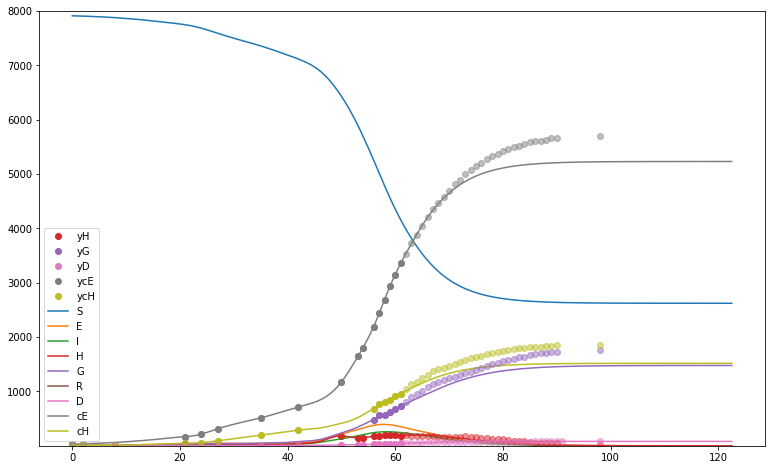

In [14]:
fig, ax=plt.subplots(figsize=[13, 8])
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time[start:clip], data_dots[start:clip], 'o', color=dColours[clr])
for clr, data_stripe in zip(dColours, getx(sols[idx]['x'])):
    ax.plot(model.observation_times, data_stripe, color=clr)
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time, data_dots, 'o', alpha=0.5, color=dColours[clr])
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
# plt.yscale('log')
print(getp(sols[idx]['x']))

In [15]:
solref = sols[idx]['x']

xref = getx(solref)
pref = getp(solref)

In [16]:
regen_params = []
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = np.log(obs[cmfilter]+1) - np.log(comp+1)
    mu = np.mean(delta)
    xd = (np.log(obs[cmfilter]+1) - np.log(comp+1) - mu).reshape(-1,1)
    cov = xd@xd.T
    regen_params.append((comp, mu, cov, cmfilter))
    

In [17]:
def resampler(params):
    out = []
    for x, m, cv, ci in params:
        mx = (np.log(x+1)+m)
        temp = np.empty((len(ci)))
        temp[:] = np.nan
        temp[ci] = np.exp(np.random.multivariate_normal(mx, cv)) - 1
        out.append(temp)
    return out


In [18]:
yd = [resampler(regen_params) for _ in range(200)]

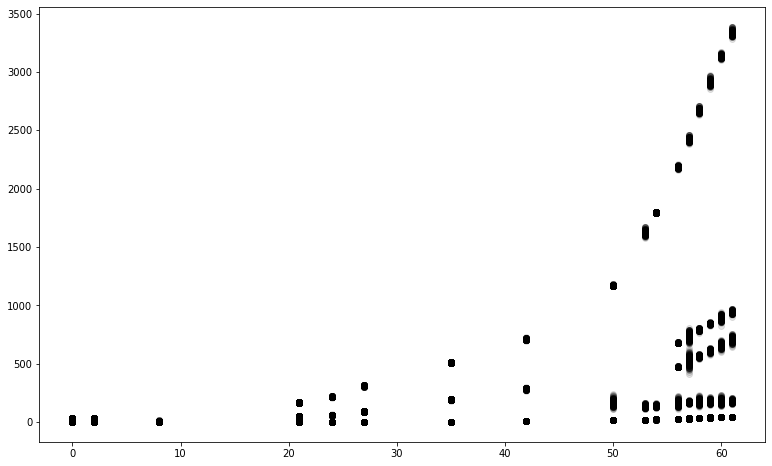

In [29]:
plt.figure(figsize=[13,8])
for y in yd:
    for x in y:
        plt.plot(objective.observation_times, x, 'ko', alpha=0.1)

In [20]:
rho = prange[idx]
resolves = []
for y in yd:
    # construct problem
    dpd = np.vstack(y).T
    objective.observations = objective.observations_from_pandas(dpd)
    objective.create_objective(model)
    objective.create_objective_functions()
    isetup = {
        'f': objective.objective,
        'x': ca.vcat(objective.input_list),
        'p': ca.hcat([objective.rho, objective.alpha]),
        'g': ca.vcat(model.xs),
    }
    isolver = ca.nlpsol('solver', 'ipopt', isetup, ipopt_opts)
    isolve_opts = {
        'x0': solref,
        'p': [rho, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    resolves.append(isolver(**isolve_opts))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 3.8306648e+002 0.00e+000 9.99e-002  -5.7 2.02e+002 -11.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  3.8306552716114368e+002   3.8306552716114368e+002
Dual infeasibility......:  2.9840367850098062e-009   2.9840367850098062e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  8.5680320362987099e-009   8.5680320362987099e-009
Overall NLP error.......:  8.5680320362987099e-009   8.5680320362987099e-009


Number of objective function evaluations             = 105
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 105
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 62
Number of Lagrangian Hessian evaluations             = 61
Total CPU secs in I

  50 1.8653955e+002 0.00e+000 3.80e-003  -5.7 2.17e+001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:  1.8653923568681967e+002   1.8653923568681967e+002
Dual infeasibility......:  1.2148195769706015e-009   1.2148195769706015e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.0292651534806708e-009   1.0292651534806708e-009
Overall NLP error.......:  1.2148195769706015e-009   1.2148195769706015e-009


Number of objective function evaluations             = 99
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 99
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 58
Number of Lagrangian Hessian evaluations             = 57
Total CPU secs in IPO

  50 2.9731519e+002 0.00e+000 5.02e+000  -3.8 8.05e+003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:  2.9729988286012031e+002   2.9729988286012031e+002
Dual infeasibility......:  9.6575109144494266e-011   9.6575109144494266e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1229715779076128e-009   1.1229715779076128e-009
Overall NLP error.......:  1.1229715779076128e-009   1.1229715779076128e-009


Number of objective function evaluations             = 113
Number of objective gradient evaluations             = 65
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 113
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 65
Number of Lagrangian Hessian evaluations             = 64
Total CPU secs in I

   nlp_jac_g  |   2.00ms ( 37.04us)   1.99ms ( 36.91us)        54
       total  | 523.00ms (523.00ms) 523.60ms (523.60ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality c

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 2.4694953e+002 0.00e+000 3.91e+002  -2.5 9.91e+001  -6.0 1.00e+000 5.00e-001f  2

Number of Iterations....: 89

                                   (scaled)                 (unscaled)
Objective...............:  2.4281865477393313e+002   2.4281865477393313e+002
Dual infeasibility......:  4.5757729391235100e-010   4.5757729391235100e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1293951122019190e-009   1.1293951122019190e-009
Overall NLP error.......:  1.1293951122019190e-009   1.1293951122019190e-009


Number of objective function evaluations             = 164
Number of objective gradient evaluations             = 90
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 164
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 90
Number of Lagrangian Hessian evaluations             = 89
Total CPU secs in I

  50 1.7754316e+002 0.00e+000 1.16e+000  -5.7 1.98e+004    -  1.00e+000 2.08e-001f  2

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:  1.7754230542523425e+002   1.7754230542523425e+002
Dual infeasibility......:  3.2729654670599515e-009   3.2729654670599515e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.4343037095242407e-009   1.4343037095242407e-009
Overall NLP error.......:  3.2729654670599515e-009   3.2729654670599515e-009


Number of objective function evaluations             = 110
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 110
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 60
Number of Lagrangian Hessian evaluations             = 59
Total CPU secs in I

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9


Number of Iterations....: 128

                                   (scaled)                 (unscaled)
Objective...............:  1.8914770456355421e+002   1.8914770456355421e+002
Dual infeasibility......:  3.0215753690755211e-012   3.0215753690755211e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800696e-009   2.5059035596800696e-009
Overall NLP error.......:  2.5059035596800696e-009   2.5059035596800696e-009


Number of objective function evaluations             = 250
Number of objective gradient evaluations             = 129
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 250
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 129
Number of Lagrangian Hessian evaluations             = 128
Total CPU secs in IPOPT (w/o function evaluations)   =      1.033
Total CPU secs in NLP function eval


Number of Iterations....: 199

                                   (scaled)                 (unscaled)
Objective...............:  1.7318152453372454e+002   1.7318152453372454e+002
Dual infeasibility......:  4.1807791341034633e-009   4.1807791341034633e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.5826083105379698e-009   1.5826083105379698e-009
Overall NLP error.......:  4.1807791341034633e-009   4.1807791341034633e-009


Number of objective function evaluations             = 357
Number of objective gradient evaluations             = 200
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 357
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 200
Number of Lagrangian Hessian evaluations             = 199
Total CPU secs in IPOPT (w/o function evaluations)   =      2.057
Total CPU secs in NLP function eval

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.4098182e+003 0.00e+000 3.85e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
  50 2.8576595e+002 0.00e+000 1.41e-001  -8.6 1.85e+003    -  9.83e-001 8.74e-001f  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:  2.8576594534458417e+002   2.8576594534458

  50 3.1465816e+002 0.00e+000 2.24e-003  -3.8 6.86e+001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:  3.1464224923530486e+002   3.1464224923530486e+002
Dual infeasibility......:  3.8290116154115919e-009   3.8290116154115919e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.5778360734740377e-009   1.5778360734740377e-009
Overall NLP error.......:  3.8290116154115919e-009   3.8290116154115919e-009


Number of objective function evaluations             = 116
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 116
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 68
Number of Lagrangian Hessian evaluations             = 67
Total CPU secs in I


Number of Iterations....: 82

                                   (scaled)                 (unscaled)
Objective...............:  2.6771323448120626e+002   2.6771323448120626e+002
Dual infeasibility......:  3.7945050540930837e-009   3.7945050540930837e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.1868138880263009e-009   9.1868138880263009e-009
Overall NLP error.......:  9.1868138880263009e-009   9.1868138880263009e-009


Number of objective function evaluations             = 158
Number of objective gradient evaluations             = 83
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 158
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 83
Number of Lagrangian Hessian evaluations             = 82
Total CPU secs in IPOPT (w/o function evaluations)   =      0.702
Total CPU secs in NLP function evaluati

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

  50 4.9845861e+002 0.00e+000 7.00e-003  -5.7 7.04e+000  -7.1 1.00e+000 1.00e+000f  1
 100 4.9832894e+002 0.00e+000 5.73e+000  -5.7 6.68e+002  -9.7 1.00e+000 5.00e-001f  2

Number of Iterations....: 114

                                   (scaled)                 (unscaled)
Objective...............:  4.9826690273411702e+002   4.9826690273411702e+002
Dual infeasibility......:  1.1989917186622753e-009   1.1989917186622753e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5941929444407108e-009   2.5941929444407108e-009
Overall NLP error.......:  2.5941929444407108e-009   2.5941929444407108e-009


Number of objective function evaluations             = 230
Number of objective gradient evaluations             = 115
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 230
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 5.3377029e+002 0.00e+000 2.00e-005  -3.8 9.18e+000    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:  5.3375423160291848e+002   5.3375423160291848e+002
Dual infeasibility......:  2.0997314505014408e-009   2.0997314505014408e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.2323140621712969e-009   1.2323140621712969e-009
Overall NLP error.......:  2.0997314505014408e-009   2.0997314505014408e-009


Number of objective function evaluations             = 108
Number of objective gradient evaluations             = 67
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 108
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 67
Number of Lagrangian Hessian evaluations             = 66
Total CPU secs in I

  50 1.4705680e+002 0.00e+000 2.64e+000  -5.7 3.53e+004    -  1.00e+000 1.49e-001f  3

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  1.4705393773424657e+002   1.4705393773424657e+002
Dual infeasibility......:  7.5360120673671981e-009   7.5360120673671981e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.7832508913571991e-009   1.7832508913571991e-009
Overall NLP error.......:  7.5360120673671981e-009   7.5360120673671981e-009


Number of objective function evaluations             = 101
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 101
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations             = 63
Total CPU secs in I

  50 3.8577313e+002 0.00e+000 1.04e+000  -2.5 7.01e+000  -5.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:  3.8157357566538155e+002   3.8157357566538155e+002
Dual infeasibility......:  3.8503774654409591e-010   3.8503774654409591e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1297224171533373e-009   1.1297224171533373e-009
Overall NLP error.......:  1.1297224171533373e-009   1.1297224171533373e-009


Number of objective function evaluations             = 153
Number of objective gradient evaluations             = 93
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 153
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 93
Number of Lagrangian Hessian evaluations             = 92
Total CPU secs in I

  50 2.1214976e+002 0.00e+000 7.63e-001  -5.7 1.18e+004    -  1.00e+000 2.37e-001f  2

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:  2.1214892093906533e+002   2.1214892093906533e+002
Dual infeasibility......:  1.0138990667942563e-009   1.0138990667942563e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1296340514998805e-009   1.1296340514998805e-009
Overall NLP error.......:  1.1296340514998805e-009   1.1296340514998805e-009


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 91
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 60
Number of Lagrangian Hessian evaluations             = 59
Total CPU secs in IPO

  50 3.6775925e+002 0.00e+000 1.23e-003  -5.7 5.25e+001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:  3.6775896280119372e+002   3.6775896280119372e+002
Dual infeasibility......:  2.9503417486502217e-009   2.9503417486502217e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.3635958410709263e-009   1.3635958410709263e-009
Overall NLP error.......:  2.9503417486502217e-009   2.9503417486502217e-009


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 57
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 91
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 57
Number of Lagrangian Hessian evaluations             = 56
Total CPU secs in IPO

 100 1.6006571e+002 0.00e+000 2.05e+000  -8.6 1.87e+003    -  1.00e+000 1.00e+000f  1
 150 1.6001295e+002 0.00e+000 3.37e+000  -8.6 2.00e+002    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 171

                                   (scaled)                 (unscaled)
Objective...............:  1.5990422127141559e+002   1.5990422127141559e+002
Dual infeasibility......:  4.6093319383593793e-012   4.6093319383593793e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009


Number of objective function evaluations             = 338
Number of objective gradient evaluations             = 172
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 338
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.8281789e+002 0.00e+000 1.92e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
  50 2.2737891e+002 0.00e+000 1.89e+000  -3.8 1.75e+003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:  2.2735953884876398e+002   2.2735953884876398e+002
Dual infeasibility......:  1.3860600213543641e-010   1.

  50 2.5872627e+002 0.00e+000 2.07e+002  -1.7 1.79e+002  -7.0 1.00e+000 5.00e-001f  2
 100 2.4759583e+002 0.00e+000 2.32e+000  -3.8 1.44e+003    -  1.00e+000 5.00e-001f  2
 150 2.4737049e+002 0.00e+000 1.85e-003  -5.7 1.35e+000    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 157

                                   (scaled)                 (unscaled)
Objective...............:  2.4737035962573731e+002   2.4737035962573731e+002
Dual infeasibility......:  2.5395978602716906e-009   2.5395978602716906e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6679495621772438e-009   2.6679495621772438e-009
Overall NLP error.......:  2.6679495621772438e-009   2.6679495621772438e-009


Number of objective function evaluations             = 280
Number of objective gradient evaluations             = 158
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 280
Number of equality

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

  50 4.4135848e+002 0.00e+000 1.58e-001  -8.6 2.01e+003    -  9.81e-001 8.84e-001f  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:  4.4135847986289980e+002   4.4135847986289980e+002
Dual infeasibility......:  5.2204119197842143e-009   5.2204119197842143e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.4751495432023396e-009   1.4751495432023396e-009
Overall NLP error.......:  5.2204119197842143e-009   5.2204119197842143e-009


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 83
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 55
Number of Lagrangian Hessian evaluations             = 54
Total CPU secs in IPO

  50 3.8169200e+002 0.00e+000 4.92e+000  -5.7 9.44e+003    -  8.86e-001 8.87e-001f  1

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:  3.8168319823515560e+002   3.8168319823515560e+002
Dual infeasibility......:  8.3315560956008481e-010   8.3315560956008481e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1267429676740980e-009   1.1267429676740980e-009
Overall NLP error.......:  1.1267429676740980e-009   1.1267429676740980e-009


Number of objective function evaluations             = 98
Number of objective gradient evaluations             = 67
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 98
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 67
Number of Lagrangian Hessian evaluations             = 66
Total CPU secs in IPO

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 3.7432839e+002 0.00e+000 6.09e+001  -2.5 9.81e+003    -  1.00e+000 1.05e-001f  4

Number of Iterations....: 82

                                   (scaled)                 (unscaled)
Objective...............:  3.7310769764310635e+002   3.7310769764310635e+002
Dual infeasibility......:  7.2652703046600686e-011   7.2652703046600686e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1222088006187524e-009   1.1222088006187524e-009
Overall NLP error.......:  1.1222088006187524e-009   1.1222088006187524e-009


Number of objective function evaluations             = 151
Number of objective gradient evaluations             = 83
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 151
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 83
Number of Lagrangian Hessian evaluations             = 82
Total CPU secs in I

In [21]:
finals = []
for resolve in resolves:
    final_count = getx(resolve['x'])[-2][-1]
    final_dead = getx(resolve['x'])[-3][-1]
    finals.append((final_count, final_dead))
finals = np.vstack(finals)

{'bodies': [<matplotlib.collections.PolyCollection at 0x1bd72b5b688>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1bd72b52108>,
 'cmins': <matplotlib.collections.LineCollection at 0x1bd73231788>,
 'cbars': <matplotlib.collections.LineCollection at 0x1bd72b5bc48>}

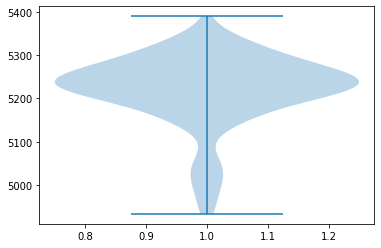

In [22]:
plt.violinplot(finals[:,0])

{'bodies': [<matplotlib.collections.PolyCollection at 0x1bd72bb6ec8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1bd73292b88>,
 'cmins': <matplotlib.collections.LineCollection at 0x1bd732acbc8>,
 'cbars': <matplotlib.collections.LineCollection at 0x1bd732b3ac8>}

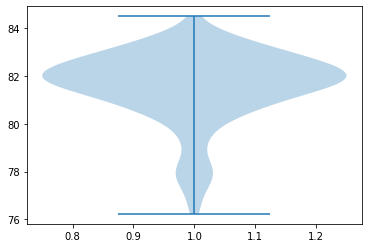

In [23]:
plt.violinplot(finals[:,1])

In [24]:
ci_0 = sorted(finals[:,0])
print(ci_0[4], ci_0[-5])

4975.219829272737 5343.359065859025


In [25]:
ci_1 = sorted(finals[:,1])
print(ci_1[4], ci_1[-5])

77.39783279205206 83.6875236299939
